## Немного об апроксимации
Из-за бутылочного горлышка в автокодировщиках, мы теряем часть информации. 
У нас всегда есть трейд-офф - какую часть информации мы готовы потерять при снижении размерности. Что нам важнее - мало факторов или снижение информации. Чем меньше будет факторов в латентном пространстве - тем более средние величины мы будем восстанавливать.

Чем больше размерность кодов, тем больше вариаций в данных автоэнкодер сможет передать. Если размерность кодов слишком мала, автоэнкодер запомнит нечто среднее по недостающим вариациям в заданной метрике (это одна из причин, почему mnist цифры все более размытые при снижении размерности кода в автоэнкодерах).



In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.cos(x1)+np.sin(x1-3)
dots = np.vstack([x1, fx]).T
noise = 0.06 * np.random.randn(*dots.shape)
dots += noise

# Цветные точки для отдельной визуализации позже
from itertools import cycle
size = 25
colors = ["r", "g", "c", "y", "m"]
idxs = range(0, x1.shape[0], x1.shape[0]//size)
vx1 = x1[idxs]
vdots = dots[idxs]

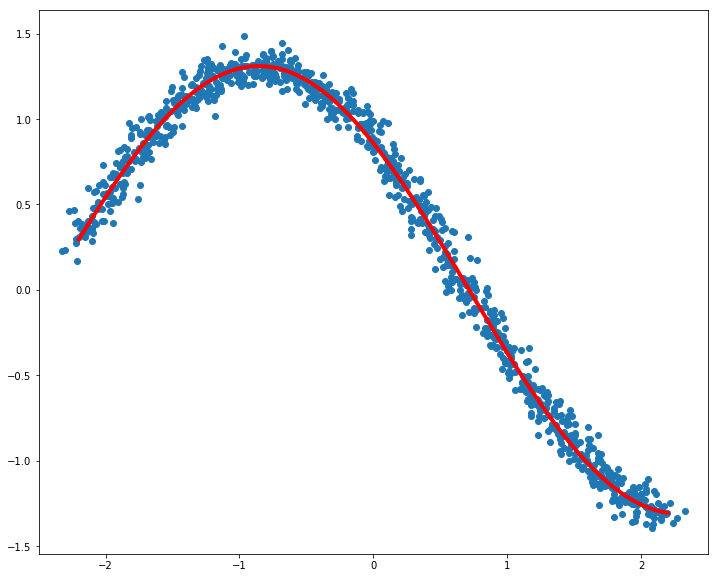

In [2]:
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1])
plt.plot(x1, fx,  color="red", linewidth=4)
plt.grid(False)

Перепишем наш автоэнкодер под новые данные

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow.keras
import tensorflow.keras, tensorflow.keras.layers as L

def build_pca_autoencoder(img_shape, code_size=36):
    # Автоэнкодер из прошлой тетрадки - давайте перепишем его!
    
    # Энкодер 
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Flatten())             # Вспомогательный слой решейпинга 
    encoder.add(L.Dense(code_size))      # Обратите внимание, что нет активации 
    
    # Декодер 
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,))) # Принимаем закодированное представление на вход
    decoder.add(L.Dense(np.prod(img_shape)))
    decoder.add(L.Reshape(img_shape))
    return encoder,decoder


In [2]:
# Сконструировали энкодер и декодер 
encoder, decoder = build_pca_autoencoder()

inp = L.Input((dots.shape[1],))  # Вход
code = encoder(inp)       # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 
# Посмотрим на параметры 
autoencoder.summary()

TypeError: build_pca_autoencoder() missing 1 required positional argument: 'img_shape'

In [6]:
autoencoder.fit(dots, dots, epochs=15, batch_size=30, verbose=1)

Epoch 1/15
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3051
Epoch 2/15
1000/1000 [==============================] - 0s 89us/step - loss: 0.1965
Epoch 3/15
1000/1000 [==============================] - 0s 91us/step - loss: 0.1480
Epoch 4/15
1000/1000 [==============================] - 0s 89us/step - loss: 0.1249
Epoch 5/15
1000/1000 [==============================] - 0s 87us/step - loss: 0.1129
Epoch 6/15
1000/1000 [==============================] - 0s 85us/step - loss: 0.1059
Epoch 7/15
1000/1000 [==============================] - 0s 87us/step - loss: 0.1017
Epoch 8/15
1000/1000 [==============================] - 0s 85us/step - loss: 0.0989
Epoch 9/15
1000/1000 [==============================] - 0s 87us/step - loss: 0.0968
Epoch 10/15
1000/1000 [==============================] - 0s 90us/step - loss: 0.0953
Epoch 11/15
1000/1000 [==============================] - 0s 84us/step - loss: 0.0942
Epoch 12/15
1000/1000 [==============================] - 0s 88us/step - los

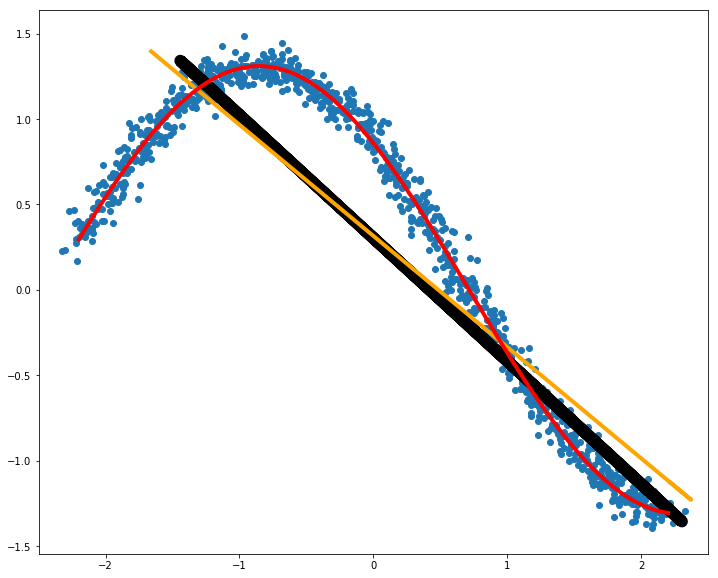

In [9]:
# Применение линейного автоэнкодера
pdots = autoencoder.predict(dots, batch_size=30)
vpdots = pdots[idxs]

# Применение PCA
from sklearn.decomposition import PCA
pca = PCA(1)
pdots_pca = pca.inverse_transform(pca.fit_transform(dots))

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots[:,0], pdots[:,1], color='black', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.grid(False)

Мы видим, что достаточно простое многообразие мы нашли. Добавим слоев.

In [29]:
# Тут у нас автоэнкодер с прошлой тетрадки - давайте перепишем его
def build_deep_autoencoder(img_shape, code_size=36):
    # code_size это размерность кодированного представления 
    
    # Энкодер 
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Flatten()) # Вспомогательный слой решейпинга 
    # Слои глубокого энкодера 
    encoder.add(L.Dense(code_size*2, activation='relu'))
    encoder.add(L.Dense(code_size, activation='linear')) # Бутылочное горлышко
    
    # Декодер 
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,))) # Принимаем закодированное представление на вход
    # Слои глубокого декодирования
    decoder.add(L.Dense(code_size*2, activation='relu'))  # Обратите внимание, что слои идут в обратном порядке
    decoder.add(L.Dense(np.prod(img_shape))) # Развёртываем картинку 
    decoder.add(L.Reshape(img_shape))
    return encoder,decoder



In [31]:
# Сконструировали энкодер и декодер 
encoder, decoder = build_deep_autoencoder()

inp = L.Input((dots.shape[1],))  # Вход
code = encoder(inp)       # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
deep_autoencoder = keras.models.Model(inp,reconstruction)
deep_autoencoder.compile('adamax','mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 
# Посмотрим на параметры 
deep_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
sequential_22 (Sequential)   (None, 1)                 2881      
_________________________________________________________________
sequential_23 (Sequential)   (None, 2)                 2882      
Total params: 5,763
Trainable params: 5,763
Non-trainable params: 0
_________________________________________________________________


In [34]:
deep_autoencoder.fit(dots, dots, epochs=200, batch_size=30, verbose=0)

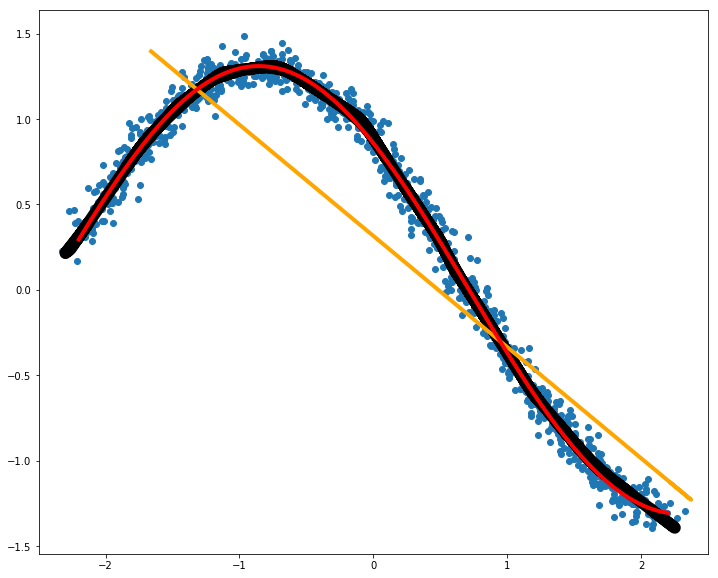

In [38]:
pdots_d = deep_autoencoder.predict(dots, batch_size=30)
vpdots_d = pdots_d[idxs]
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots_d[:,0], pdots_d[:,1], color='black', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.grid(False)



Все же у достаточно сложного автоэнкодера есть возможность переобучиться. Продемонстрируем это!
Мы берем и показываем одни и теже точки автоэнкодеру множество раз.

In [ ]:
x_train_oft = np.vstack([dots[idxs]]*4000)

# Сконструировали энкодер и декодер 
encoder, decoder = build_deep_autoencoder()

inp = L.Input((dots.shape[1],))  # Вход
code = encoder(inp)       # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
deep_autoencoder = keras.models.Model(inp,reconstruction)
deep_autoencoder.compile('adamax','mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 
deep_autoencoder.fit(x_train_oft, x_train_oft, epochs=200, batch_size=30, verbose=0)


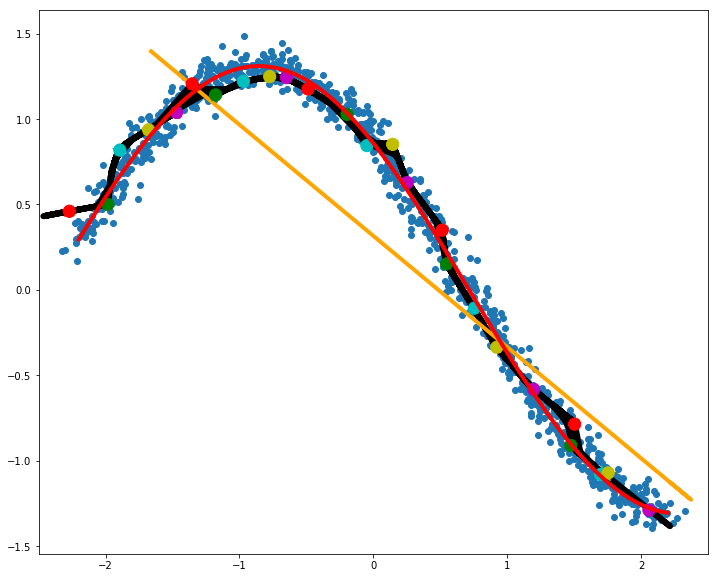

In [41]:
pdots_d = deep_autoencoder.predict(dots, batch_size=30)
vpdots_d = pdots_d[idxs]

plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx, color="red", linewidth=4, zorder=10)
plt.plot(pdots_d[:,0], pdots_d[:,1], color='black', linewidth=6, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vpdots_d[:,0], vpdots_d[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

Мы видим, что наша линия проходит через конкретные точки, и очень плохо описывает правильное многообразие.

В теории мы можем апроксимизировать какое угодно распределение.
Мы стремимся найти такое латентное пространство, 
где мы небольшие сдвиги в латентных переменных все равно остаются в том же классе.  

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

# Сверточный автоэнкодер
def create_deep_conv_ae():
    input_img =Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
c_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),verbose=1)

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

# Гомотопия по прямой между объектами или между кодами
def plot_homotopy(frm, to, n=10, decoder=None):
    z = np.zeros(([n] + list(frm.shape)))
    for i, t in enumerate(np.linspace(0., 1., n)):
        z[i] = frm * (1-t) + to * t
    if decoder:
        plot_digits(decoder.predict(z, batch_size=n))
    else:
        plot_digits(z)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 291us/sample - loss: 0.1843 - val_loss: 0.1016
Epoch 2/50
60000/60000 [==============================] - 15s 251us/sample - loss: 0.0951 - val_loss: 0.0885
Epoch 3/50
60000/60000 [==============================] - 15s 252us/sample - loss: 0.0869 - val_loss: 0.0837
Epoch 4/50
60000/60000 [==============================] - 15s 251us/sample - loss: 0.0835 - val_loss: 0.0807
Epoch 5/50
60000/60000 [==============================] - 15s 251us/sample - loss: 0.0810 - val_loss: 0.0805
Epoch 6/50
60000/60000 [==============================] - 15s 246us/sample - loss: 0.0797 - val_loss: 0.0777
Epoch 7/50
60000/60000 [==============================] - 15s 248us/sample - loss: 0.0786 - val_loss: 0.0769
Epoch 8/50
60000/60000 [==============================] - 15s 246us/sample - loss: 0.0776 - val_loss: 0.0763
Epoch 9/50
60000/60000 [==============================] - 15s 250us/sample - l

In [ ]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

# Гомотопия по прямой между объектами или между кодами
def plot_homotopy(frm, to, n=10, decoder=None):
    z = np.zeros(([n] + list(frm.shape)))
    for i, t in enumerate(np.linspace(0., 1., n)):
        z[i] = frm * (1-t) + to * t
    if decoder:
        plot_digits(decoder.predict(z, batch_size=n))
    else:
        plot_digits(z)

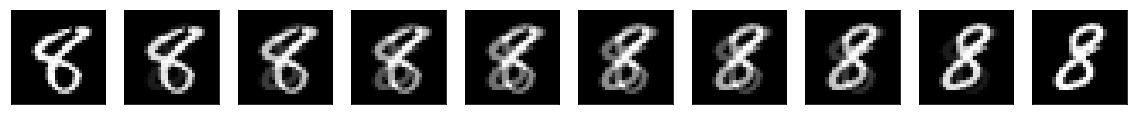

In [49]:
# Гомотопия между первыми двумя восьмерками
frm, to = x_test[y_test == 8][1:3]
plot_homotopy(frm, to)



Если наше латентное пространтсво корректное, мы нашли правильно параметаризованное латентное пространство, 
то небольшие сдвиги в этом пространстве должны давать разумные результаты: 

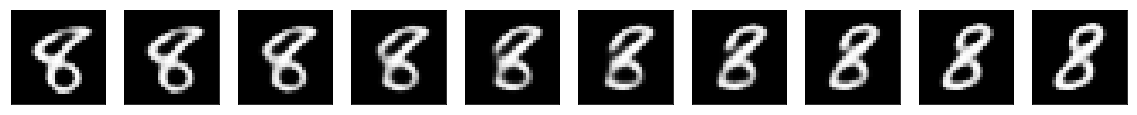

In [50]:
codes = c_encoder.predict(x_test[y_test == 8][1:3])
plot_homotopy(codes[0], codes[1], n=10, decoder=c_decoder)

## Что такое картинка?
Можно рассмотреть генеральную совокупность как некоторый процесс генерации данных X, 
который зависит от некоторого количества скрытых переменных Z (случайных величин). 
Размерность данных X может быть намного выше, 
чем размерность скрытых случайных величин Z, которые эти данные определяют.
Рассмотрим процесс генерации очередной цифры: то, как будет выглядеть цифра, может зависеть от множества факторов:
* желаемой цифры,
* толщины штриха,
* наклона цифры,
* аккуратности,
* и т.д.

в идеале автоэнкодер должен восстановить случайные величины, которые получаются в этом пространстве.
Для определенности введем некоторые обозначения на примере цифр:

* X — случайная величина, сама картинки 28х28,
* Z — случайная величина скрытых факторов, определяющих цифру на картинке,
* p(X) — вероятностное распределение изображений цифр на картинках,
    т.е. вероятность конкретного изображения цифры в принципе быть
    нарисованным (если картинка не похожа на цифру, то эта вероятность крайне мала),
* p(Z) — вероятностное распределение скрытых факторов,
    например, распределение толщины штриха,
* p(Z|X) — распределение вероятности скрытых факторов 
    при заданной картинке (к одной и той же картинке могут
                       привести различное сочетание скрытых переменных и шума),
* p(X|Z) — распределение вероятности картинок при заданных
            скрытых факторах, одни и те же факторы могут привести к разным картинкам 
            (один и тот же человек в одних и тех же условиях не рисует абсолютно одинаковые цифры),
* p(X,Z) — совместное распределение X и Z, 
    наиболее полное понимание данных, необходимое для генерации новых объектов.

             p(X,Z) = p(X|Z) p(Z)

* p(X|Z) нам приближает декодер, но p(Z) на данный момент мы пока еще не понимаем.

In [ ]:
from keras.layers import Flatten, Reshape, Dense
from keras.regularizers import L1L2
from keras.optimizers import Adam

def create_deep_sparse_ae(lambda_l1):
    # Размерность кодированного представления
    encoding_dim = 16

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*4, activation='relu')(flat_img)
    x = Dense(encoding_dim*3, activation='relu')(x)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1, 0))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    x = Dense(encoding_dim*4, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_deep_sparse_ae(0.)
autoencoder.compile(optimizer=Adam(0.0003), loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                      epochs=200,
                      batch_size=64,
                      shuffle=True,
                      validation_data=(x_test, x_test))


n = 10
imgs = x_test[:n]
decoded_imgs = autoencoder.predict(imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)


 В идеале должно получится вот так - но у меня лапки (
 
 ![title](Must_be.png)
 

А при разряженном автокодировщике вот так!

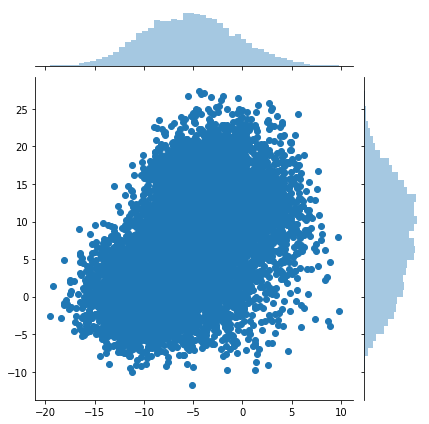

In [59]:
codes = encoder.predict(x_test)
sns.jointplot(codes[:,1], codes[:,3])

Для управлением распределением используют различные подходы - 
один из практикуемых подходов, это использование sparse автоэнкодера. Он должен(но не обязан!)
схлопывать распределения друг к другу, чтобы делать их более независимыми.